In [1]:
from numpy import*
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import pandas as pd
%matplotlib inline

Cilj ovog projekta je provjeriti učinkovitost neuronskih mreža u previđanju dinamike nelinearnih sustava. Konkretno u ovom slučaju promatramo Van der Polov oscilator čija je dinamika dana diferencijalnom jednadžbom:
$$\begin{pmatrix}\dot{x}\\\dot{y} \end{pmatrix} = \begin{pmatrix}y \\ \mu (1- x^2)y -x \end{pmatrix}$$
Ideja je uzeti neki broj parova $(x,y)$ te izračunati pripadni $(\dot{x},\dot{y})$ i s tim istrenirati neuronsku mrežu da sama za dani $(x,y)$ predviđa $(\dot{x},\dot{y})$.
Pri provjeri kvalitete rezultata često koristim grafove tzv. faznog toka što je u biti vektorsko polje u $x-y$ ravnini gdje je svakoj točki pridružen vektor $(\dot{x},\dot{y})$.

Ovo je egzaktni fazni tok kojeg želimo dobiti neuronskom mrežom.


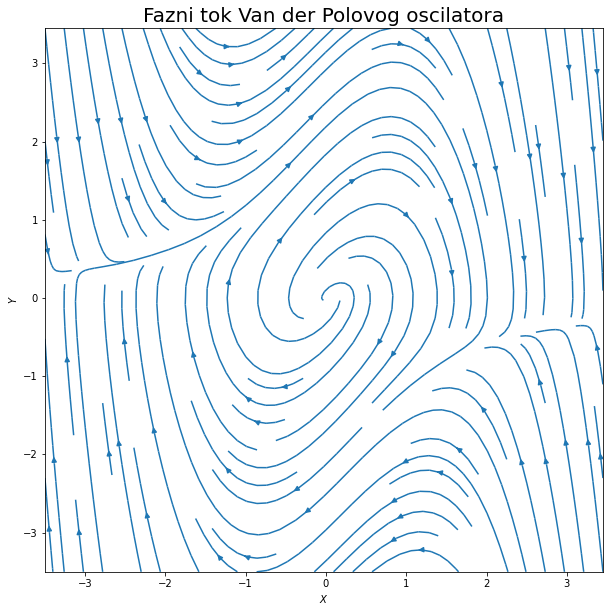

In [2]:
#Korisne funkcije
def van_der_pol(state,t,mu = 1):
    """Generira egzaktnu diferencijalnu jednadžbu sustava"""
    x = state[0]
    dx = state[1]
    d2x = -x  + mu*( 1 - x**2 )*dx
    
    return array([dx,d2x])
dt = 0.01   

def vector_field(x,dx,dt = dt,mu = 1):
    
    ux = dx
    uy = -x + mu*(1 - x**2)*dx
    return ux,uy


x_mesh = arange(-3.5,3.5,5e-2)
y_mesh = arange(-3.5,3.5,5e-2)
Npts = len(x_mesh)
u = zeros([Npts,Npts])
v = zeros([Npts,Npts])

for i in range(Npts):
    for j in range(Npts):
        u[j,i],v[j,i] = vector_field(x_mesh[i],y_mesh[j])

        
X,Y = meshgrid(x_mesh,y_mesh) 
frame,fig =plt.subplots(figsize = (10,10))
fig.streamplot(x_mesh,y_mesh,u,v)
# q = fig.quiver(X[::5,::5],Y[::5,::5],u[::5,::5],v[::5,::5],units = "width",color = "blue",label ="fazni tok")
# qk = fig.quiverkey(q, 0.9, 0.9, 2,label = "")
#fig.legend()
fig.set_title("Fazni tok Van der Polovog oscilatora",fontsize = 20)
fig.set_xlabel(r"$X$")
fig.set_ylabel(r"$Y$")
print("Ovo je egzaktni fazni tok kojeg želimo dobiti neuronskom mrežom.")

In [3]:
#Definiranje modela
#Arhitektura 2 x 8 x 8 x 2
model= keras.Sequential([layers.BatchNormalization(input_shape = [2]),
                        layers.Dense(8,activation = "swish"),
                        layers.BatchNormalization(),
                        layers.Dense(8,activation = "swish"),
                        layers.BatchNormalization(),
                        layers.Dense(2)])


opt =keras.optimizers.Adam(
    learning_rate=0.005)

model.compile(optimizer = opt,
               loss = 'mae')


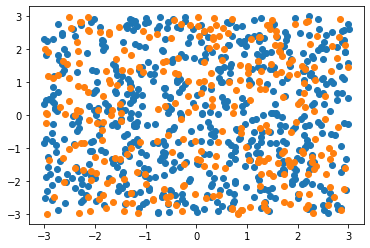

In [4]:
#Generiranje podataka za učenje modela
#Za provjeru i za testiranje modela
eps = 1e-2
Ntrain = 600 #Originalno 600
trainX =  random.uniform(-3,3+eps,(Ntrain,2))
trainY = list()

Ntest = 300
testX =  random.uniform(-3,3+eps,(Ntest,2))
testY = list()

Nvalid = 300
validX =  random.uniform(-3,3+eps,(Nvalid,2))
validY = list()

for i in range(Ntrain):
    trainY.append(vector_field(trainX[i][0],trainX[i][1]))    
for i in range(Ntest):
    testY.append(vector_field(testX[i][0],testX[i][1]))
for i in range(Nvalid):
    validY.append(vector_field(validX[i][0],validX[i][1]))
    
trainY = array(trainY)
testY = array(testY)
validY = array(validY)
plt.scatter(trainX[:,0],trainX[:,1])
plt.scatter(validX[:,0],validX[:,1])

In [5]:
#Treniranje modela
history = model.fit(trainX,trainY,
                   validation_data=(validX,validY),
                    batch_size = 64,
                    epochs = 1000,
                    verbose = False
                   )

10/10 [==============================] - 0s 721us/step - loss: 0.3188


0.31877607107162476

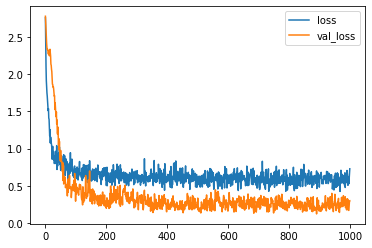

In [6]:
#Točnost modela
history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot()
model.evaluate(testX,testY)

Prvi istrenirani model učio je na skupu uniformno distribuirani tokčaka u $x-y$ ravnini te se čini da poprilično dobro predviđa ponašanje sustava (vidi preklopljenu sliku - ćelija niže). Problem s ovim pristupom jest da u stvarnosti ne znamo kako se sustav ponaša u velikom broju početnih točaka, ono što u praksi imamo najčešće je nekolicina trajektorija po kojima je evolvirao sustav. 

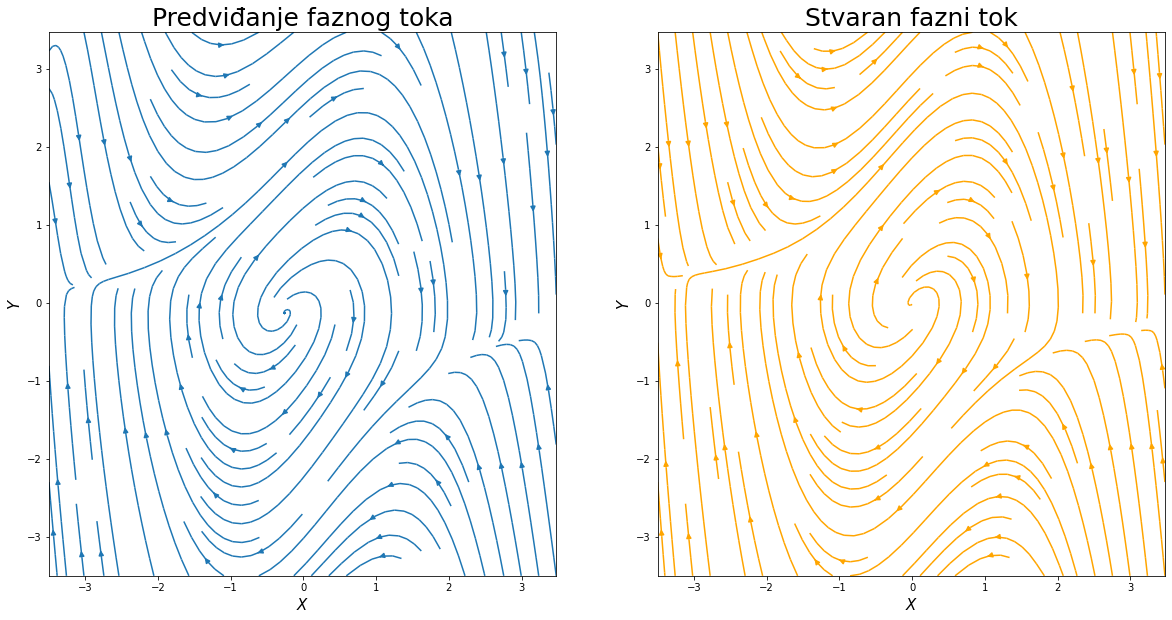

In [7]:
#Provjera kako model radi na nasumično odabranim točkama
#Cilj mu je pogoditi fazni tok u točku odnosno diferencijanu jednadžbu
x_mesh = arange(-3.5,3.5,7/300)
y_mesh = arange(-3.5,3.5,7/300)
u = zeros((len(x_mesh),len(x_mesh)))
v = zeros((len(x_mesh),len(x_mesh)))

data =[]
for i in range(len(x_mesh)):
    for j in range(len(y_mesh)):
        data.append([x_mesh[j],y_mesh[i]])   
        
        
data = array(data)
pred = model.predict(data)
pred =pred.reshape(300,300,2)


for i in range(len(x_mesh)):
    for j in range(len(y_mesh)):
        u[j,i],v[j,i] = vector_field(x_mesh[i],y_mesh[j])


frame,fig = plt.subplots(1,2,figsize = (20,10))
fig[0].streamplot(x_mesh,y_mesh,pred[:,:,0],pred[:,:,1],density = 1)
fig[1].streamplot(x_mesh,y_mesh,u,v,density = 1,color ="orange")
fig[0].set_title("Predviđanje faznog toka",fontsize = 25)
fig[1].set_title("Stvaran fazni tok",fontsize = 25)
fig[0].set_xlabel(r"$X$",fontsize = 15)
fig[0].set_ylabel(r"$Y$",fontsize = 15)
fig[1].set_xlabel(r"$X$",fontsize = 15)
fig[1].set_ylabel(r"$Y$",fontsize = 15)
print()
frame.savefig("Usporedba")


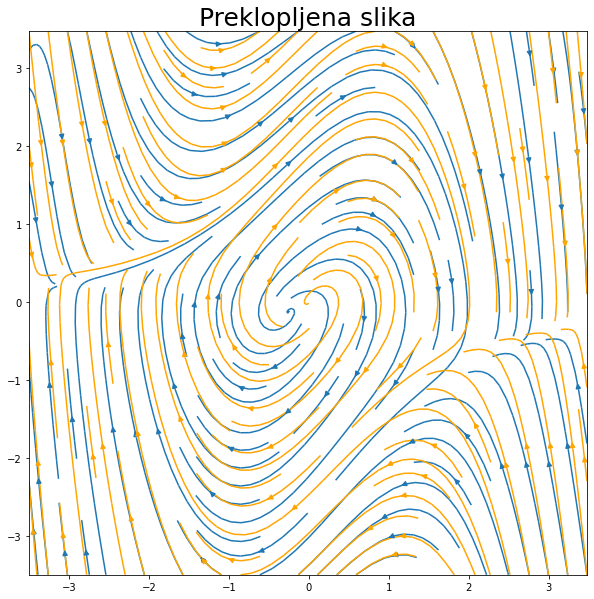

In [8]:
frame,fig = plt.subplots(figsize = (10,10))
dns = 1
fig.streamplot(x_mesh,y_mesh,pred[:,:,0],pred[:,:,1],density = dns)
fig.streamplot(x_mesh,y_mesh,u,v,density = dns,color ="orange")

fig.set_title("Preklopljena slika",fontsize = 25)
frame.savefig("Preklop")


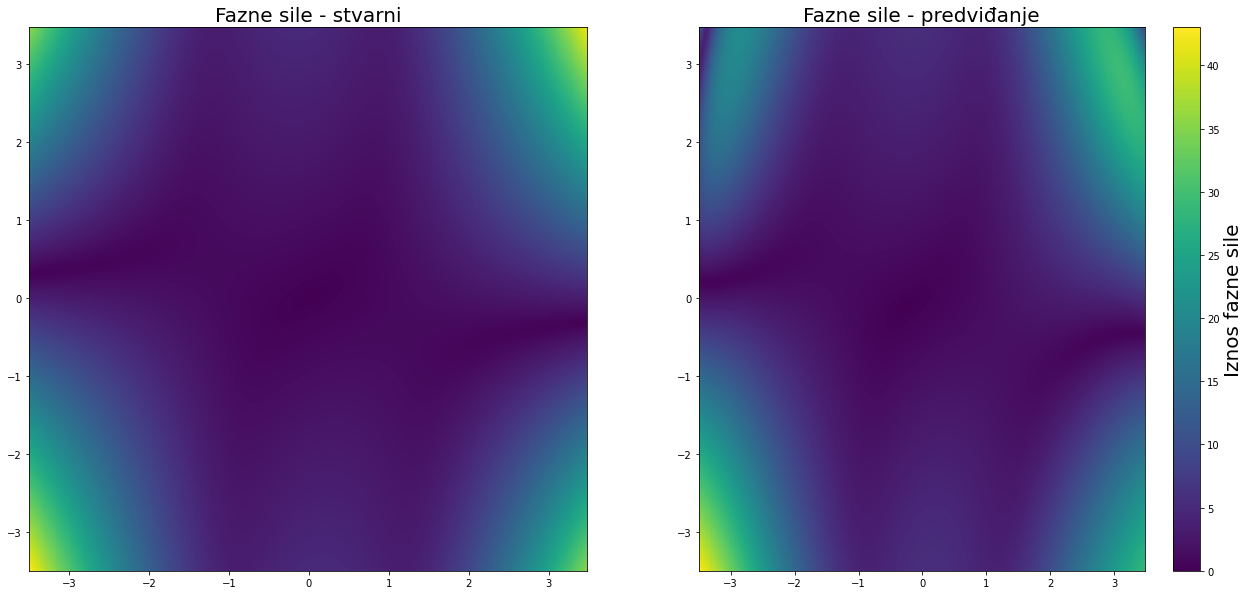

In [9]:
size_real = zeros((300,300))
size_neural = zeros((300,300))

for i in range(300):
    for j in range(300):
        size_real[j,i] = sqrt(u[j,i]**2 + v[j,i]**2)
        size_neural[j,i] = sqrt(pred[j,i,0]**2 + pred[j,i,1]**2)
        
X,Y = meshgrid(x_mesh,y_mesh)
frame,fig =plt.subplots(1,2,figsize =(22,10))
mp = fig[0].pcolor(X,Y,size_real)
fig[1].pcolor(X,Y,size_neural)
cs = frame.colorbar(mp,cmap='jet')
cs.set_label('Iznos fazne sile',size=20)
fig[0].set_title("Fazne sile - stvarni",fontsize =20)
fig[1].set_title("Fazne sile - predviđanje",fontsize =20)
frame.savefig("Iznos_faznih sila")

In [10]:
#Učenje kontinuacije dinamike
# #Podatke uzima s jedne krivulje
t = arange(0,15,1e-2)
L = len(t)
Npts = 500
initial_train =[0.1,0.1]
train_traj = odeint(van_der_pol,initial_train,t)
X_train = train_traj[::2,:]

initial_val = [0.3,0.4]
val_traj = odeint(van_der_pol,initial_val,t)
X_val = val_traj[::2,:]
#Y_val = zeros((Npts,2))



initial_test = [-0.21,0.15]
test_traj = odeint(van_der_pol,initial_test,t)
X_test = test_traj[::2,:]
#Y_test = zeros((Npts,2))

Y_train,Y_test,Y_val = [],[],[]

for i in range(len(X_train)):
#     Y_train[i,:] += vector_field(X_train[i,0],X_train[i,1])
#     Y_val[i,:] += vector_field(X_val[i,0],X_val[i,1])
#     Y_test[i,:] += vector_field(X_test[i,0],X_test[i,1])
    Y_train.append(vector_field(X_train[i,0],X_train[i,1]))

for i in range(len(X_val)):
    Y_test.append(vector_field(X_test[i,0],X_test[i,1]))
    Y_val.append(vector_field(X_val[i,0],X_val[i,1]))
    
Y_train = array(Y_train)
Y_test = array(Y_test)
Y_val = array(Y_val)


In [13]:
act = "swish"

model2 = keras.Sequential([layers.BatchNormalization(input_shape = [2]),
                           layers.Dense(8,activation = act),
                           layers.BatchNormalization(),
                           layers.Dense(8,activation  = act),
                           layers.BatchNormalization(),
                           layers.Dense(2)
])

#Optimizaciski algoritam
opt =keras.optimizers.Adam(
    learning_rate=0.001)
#mse - Mean square error - to želiš minimizirati
model2.compile(optimizer = opt,
               loss = 'mae')


early_stopping = keras.callbacks.EarlyStopping(
    min_delta=0.01, # minimium amount of change to count as an improvement
    patience=200, # how many epochs to wait before stopping
    restore_best_weights=True
)




In [18]:
history2 = model2.fit(X_train,Y_train,
                      validation_data = (X_val,Y_val),
                      batch_size = 64,
                      epochs = 1000,
                    callbacks = [early_stopping],
                    verbose  = False
)




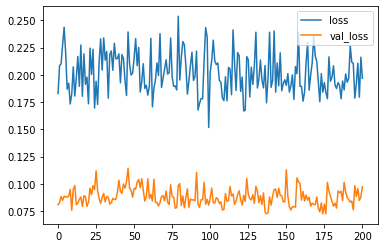

In [19]:
history_df2 = pd.DataFrame(history2.history
                        )
history_df2.loc[:,['loss','val_loss']].plot()

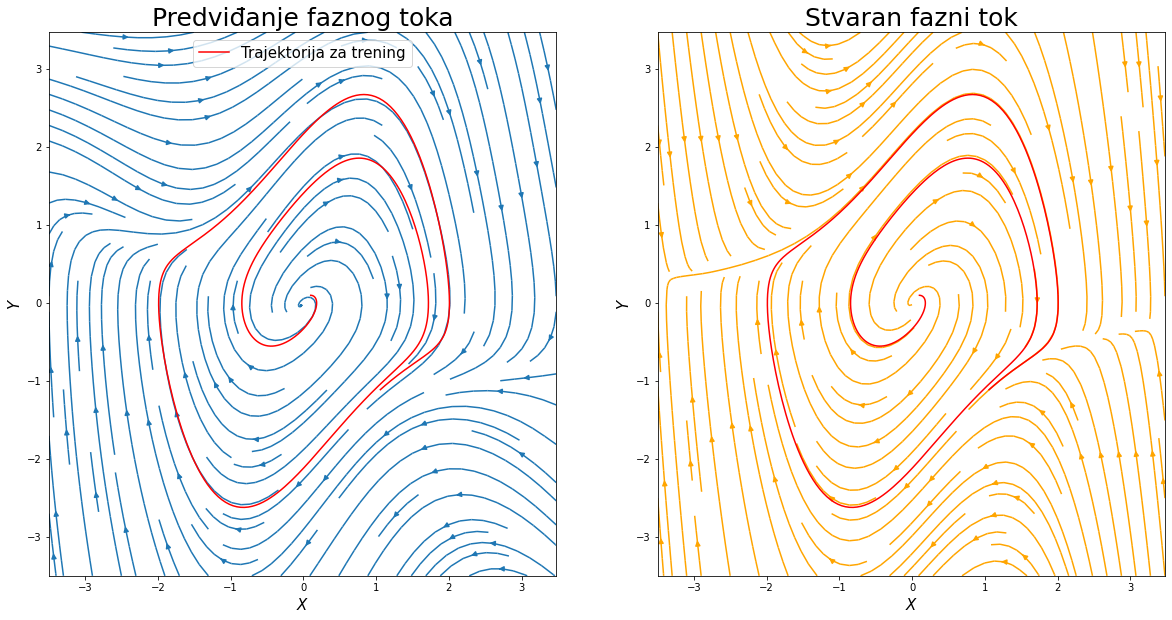

In [20]:
span = 3.5

x_mesh = arange(-span,span,2*span/300)
y_mesh = arange(-span,span,2*span/300)
u = zeros((len(x_mesh),len(x_mesh)))
v = zeros((len(x_mesh),len(x_mesh)))

data =[]
for i in range(len(x_mesh)):
    for j in range(len(y_mesh)):
        data.append([x_mesh[j],y_mesh[i]])   
        
        
data = array(data)
pred = model2.predict(data)
pred =pred.reshape(300,300,2)


for i in range(len(x_mesh)):
    for j in range(len(y_mesh)):
        u[j,i],v[j,i] = vector_field(x_mesh[i],y_mesh[j])


frame,fig = plt.subplots(1,2,figsize = (20,10))
fig[0].streamplot(x_mesh,y_mesh,pred[:,:,0],pred[:,:,1],density = 1.2)
fig[1].streamplot(x_mesh,y_mesh,u,v,density = 1.2,color ="orange")
fig[0].set_title("Predviđanje faznog toka",fontsize = 25)
fig[1].set_title("Stvaran fazni tok",fontsize = 25)
fig[0].set_xlabel(r"$X$",fontsize = 15)
fig[0].set_ylabel(r"$Y$",fontsize = 15)
fig[1].set_xlabel(r"$X$",fontsize = 15)
fig[1].set_ylabel(r"$Y$",fontsize = 15)
print()
#fig[0].plot(X,Y)
fig[0].plot(X_train[:,0],X_train[:,1],color ="red",label ="Trajektorija za trening")

fig[1].plot(X_train[:,0],X_train[:,1],color = "red")
fig[0].legend(fontsize = 15)
frame.savefig("Krivulje_usporedba")